In [25]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier

In [26]:
df = pd.read_csv('/Users/ericjian/Downloads/KaggleV2-May-2016.csv')
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# Data Cleaning 

In [27]:
#Rename columns with spelling errors
df.rename(columns = {'ApointmentData':'AppointmentData',
                         'Alcoolism': 'Alchoholism',
                         'Hipertension': 'Hypertension',
                         'Handcap': 'Handicap'}, inplace = True)
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No-show'],
      dtype='object')

In [28]:
#Check missing values
df.isnull().values.any()

False

In [29]:
#Change format to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [30]:
#Remove dates where days elapsed between scheduled and appointment days are negative
df['DaysElapsed']= df['AppointmentDay'] - df['ScheduledDay']
# df['DaysElapsed'] = df['DaysElapsed'].astype(str)
df['DaysElapsed'] = df['DaysElapsed'].dt.days
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,DaysElapsed
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1


In [31]:
#Drop impossible ages
df.drop(df[df['Age'] < 0].index, inplace = True)

#Drop impossible elapsed schedulings
df.drop(df[df['DaysElapsed'] < 0].index, inplace = True)
df['DaysElapsed'] = df['DaysElapsed'].astype(int)


In [32]:
#Convert appointment day to days of the week
df['DayOfTheWeek'] = df['AppointmentDay'].dt.dayofweek
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,DaysElapsed,DayOfTheWeek
5,9.598513e+13,5626772,F,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,1,4
6,7.336882e+14,5630279,F,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1,4
7,3.449833e+12,5630575,F,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1,4
9,7.812456e+13,5629123,F,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,1,4
10,7.345362e+14,5630213,F,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,No,1,4


# Data Visualization

## Box Plot

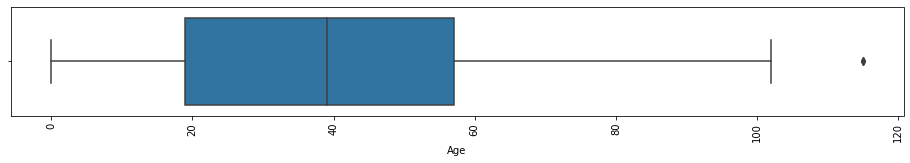

In [33]:
#Box plot of ages
plt.figure(figsize = (16,2))
plt.xticks(rotation = 90)
agebox = sns.boxplot(x = df['Age'])

## Countplots

In [34]:
df['No-show'].value_counts()

No     51437
Yes    20522
Name: No-show, dtype: int64

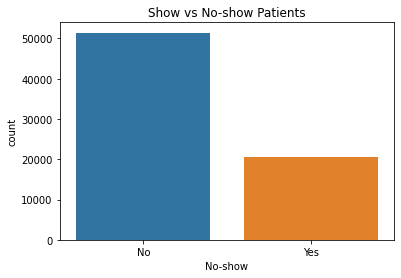

In [35]:
showplt = sns.countplot(x=df['No-show'], data=df)
showplt.set_title("Show vs No-show Patients")
plt.show()

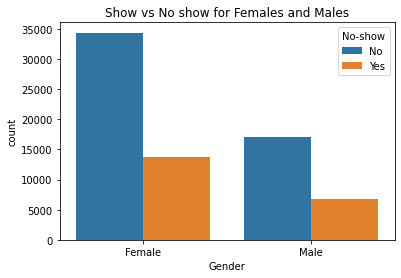

In [36]:
gender = sns.countplot(x = df['Gender'], hue = df['No-show'], data = df)
gender.set_title("Show vs No show for Females and Males")
x_ticks_labels = ['Female', 'Male']
gender.set_xticklabels(x_ticks_labels)
plt.show()

In [37]:
df['Gender'].value_counts()

F    48070
M    23889
Name: Gender, dtype: int64

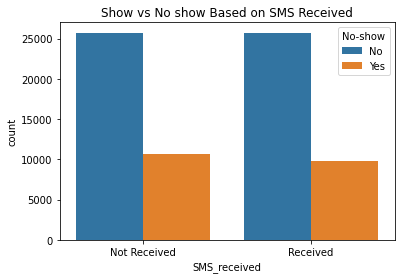

In [38]:
gender = sns.countplot(x = df['SMS_received'], hue = df['No-show'], data = df)
gender.set_title("Show vs No show Based on SMS Received")
x_ticks_labels = ['Not Received', 'Received']
gender.set_xticklabels(x_ticks_labels)
plt.show()

In [39]:
df['Neighbourhood'].nunique()

80

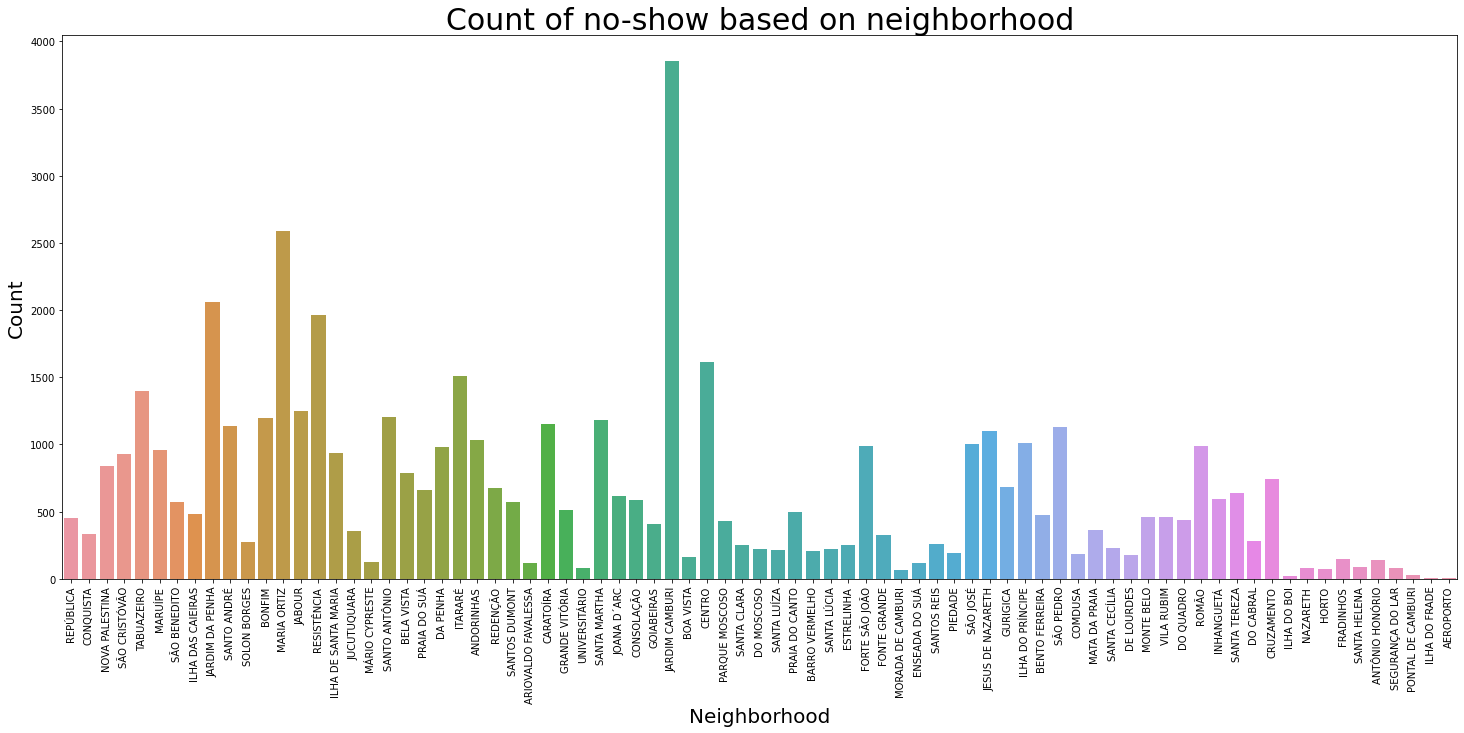

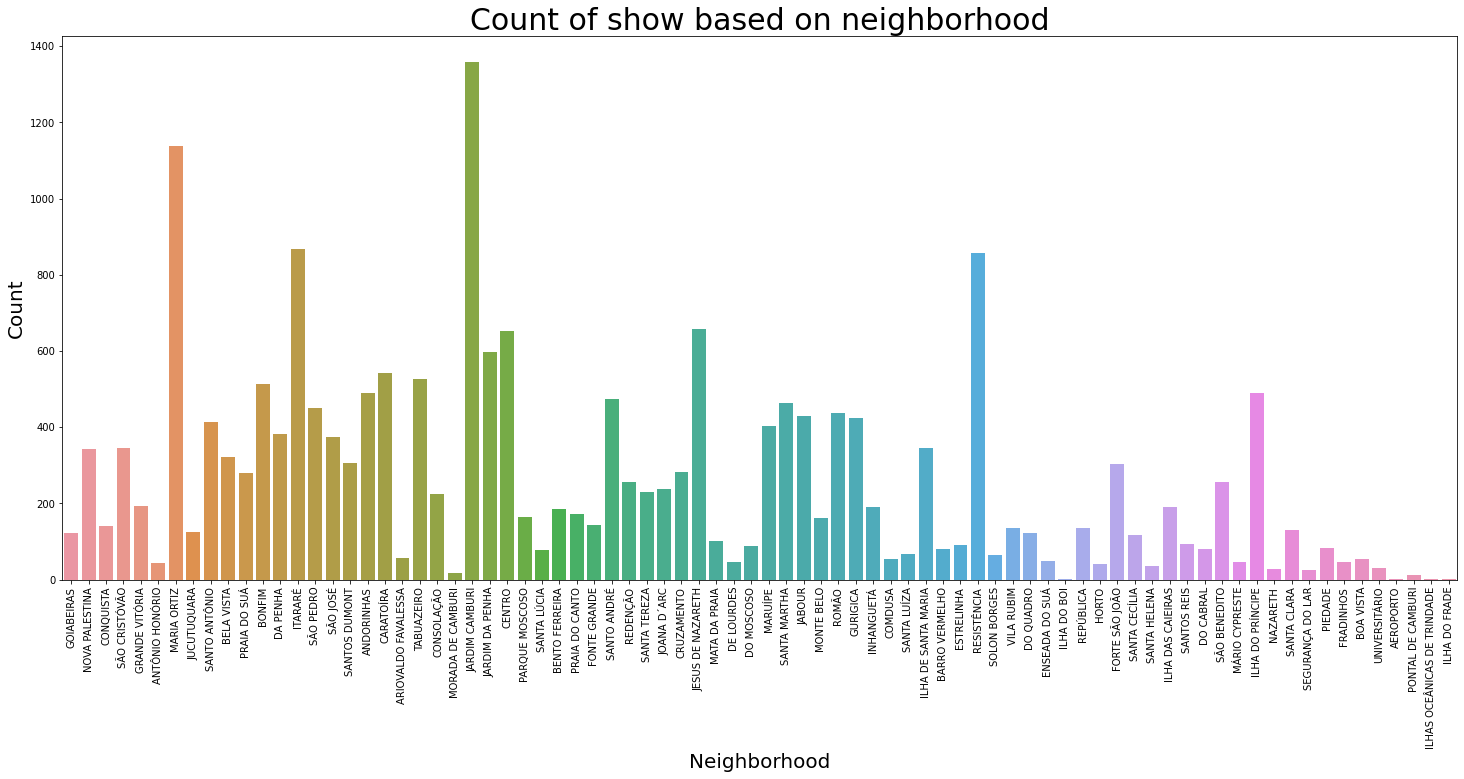

<Figure size 1800x720 with 0 Axes>

In [40]:
#Graph shows vs no shows by neighborhood
noshow = df.loc[df['No-show'] == 'No']
yesshow = df.loc[df['No-show'] == 'Yes']

plt.figure(figsize=(25,10))
ax = sns.countplot(x="Neighbourhood", data=noshow)
plt.xticks(rotation=90)
plt.figure(figsize=(25,10))

bx = sns.countplot(x="Neighbourhood", data=yesshow)
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.figure(figsize=(25,10))

ax.set_xlabel('Neighborhood', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.set_title('Count of no-show based on neighborhood', fontsize = 30)

bx.set_xlabel('Neighborhood', fontsize = 20)
bx.set_ylabel('Count', fontsize = 20)
bx.set_title('Count of show based on neighborhood', fontsize = 30)
plt.show()


## Histogram

No     51437
Yes    20522
Name: No-show, dtype: int64

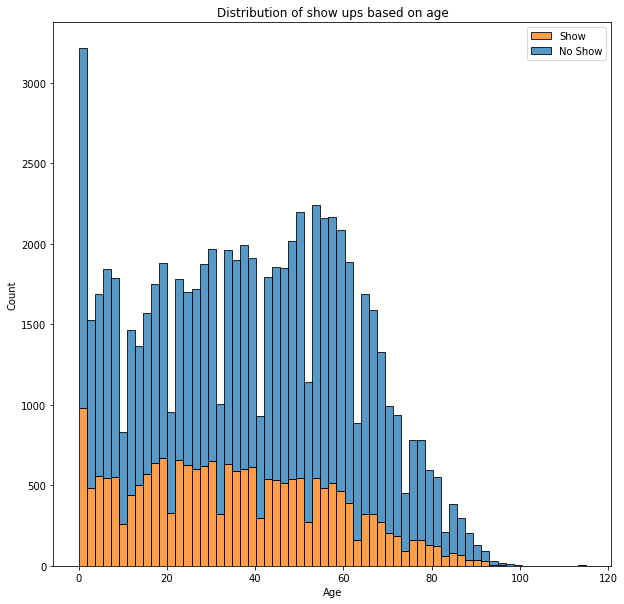

In [41]:
show = df[['No-show', 'Age']]
show

plt.figure(figsize=(10,10))
sns.histplot(data = show, x = 'Age', hue = 'No-show', multiple = 'stack')
plt.title('Distribution of show ups based on age')
plt.legend(labels = ['Show', 'No Show'])

show['No-show'].value_counts()

# Feature Engineering

In [42]:
#Change strings into binary integers
factor_dict = {
    'No-show': {
        'Yes': 1, 
        'No': 0
    },
    'Gender': {
        'M': 1, 
        'F': 0
    }
}
df.replace(factor_dict, inplace = True)
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,DaysElapsed,DayOfTheWeek
5,9.598513e+13,5626772,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,0,1,4
6,7.336882e+14,5630279,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,1,1,4
7,3.449833e+12,5630575,0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,1,1,4
9,7.812456e+13,5629123,0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,0,1,4
10,7.345362e+14,5630213,0,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,4


In [43]:
#Count no shows for every unique patient id
df['MissedAppts'] = df.groupby('PatientId')['No-show'].apply(lambda x: x.cumsum())
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,DaysElapsed,DayOfTheWeek,MissedAppts
5,9.598513e+13,5626772,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,0,1,4,0
6,7.336882e+14,5630279,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,1,1,4,1
7,3.449833e+12,5630575,0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,1,1,4,1
9,7.812456e+13,5629123,0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,0,1,4,0
10,7.345362e+14,5630213,0,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,4,0


In [44]:
# One-hot encodes all neighbourhood and handicap
one_hotdf = pd.get_dummies(data = df, columns=['Neighbourhood', 'Handicap'])
# one_hotdf = pd.get_dummies(data = df, columns=['Handicap'])
one_hotdf['PatientId'] = df['PatientId']
one_hotdf.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,...,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4
5,9.598513e+13,5626772,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6,7.336882e+14,5630279,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,3.449833e+12,5630575,0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,7.812456e+13,5629123,0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,7.345362e+14,5630213,0,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [45]:
#Drop all duplicate columns from df
one_hotdf.drop(one_hotdf.iloc[:, 1:16], inplace = True, axis = 1)

In [46]:
#Merge one hot encoded table to original table
df = df.merge(one_hotdf, left_on='PatientId', right_on='PatientId')
df.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,...,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4
0,9.598513e+13,5626772,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,9.598513e+13,5626772,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,9.598513e+13,5732325,0,2016-05-24 11:19:51+00:00,2016-06-01 00:00:00+00:00,76,REPÚBLICA,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,9.598513e+13,5732325,0,2016-05-24 11:19:51+00:00,2016-06-01 00:00:00+00:00,76,REPÚBLICA,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,7.336882e+14,5630279,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [47]:
#Drop features that won't affect the outcome
df.drop(['AppointmentID', 'PatientId', 'Neighbourhood', 'ScheduledDay', 'AppointmentDay', 'Handicap'], axis=1, inplace = True)

# Modeling the Data

In [48]:
#Standardizing Data
X = (df - np.min(df)) / (np.max(df) - np.min(df))

y = df['No-show']
X.drop(['No-show'], axis=1, inplace = True)
X.columns

Index(['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes',
       'Alcoholism', 'SMS_received', 'DaysElapsed', 'DayOfTheWeek',
       'MissedAppts', 'Neighbourhood_ANDORINHAS',
       'Neighbourhood_ANTÔNIO HONÓRIO', 'Neighbourhood_ARIOVALDO FAVALESSA',
       'Neighbourhood_BARRO VERMELHO', 'Neighbourhood_BELA VISTA',
       'Neighbourhood_BENTO FERREIRA', 'Neighbourhood_BOA VISTA',
       'Neighbourhood_BONFIM', 'Neighbourhood_CARATOÍRA',
       'Neighbourhood_CENTRO', 'Neighbourhood_COMDUSA',
       'Neighbourhood_CONQUISTA', 'Neighbourhood_CONSOLAÇÃO',
       'Neighbourhood_CRUZAMENTO', 'Neighbourhood_DA PENHA',
       'Neighbourhood_DE LOURDES', 'Neighbourhood_DO CABRAL',
       'Neighbourhood_DO MOSCOSO', 'Neighbourhood_DO QUADRO',
       'Neighbourhood_ENSEADA DO SUÁ', 'Neighbourhood_ESTRELINHA',
       'Neighbourhood_FONTE GRANDE', 'Neighbourhood_FORTE SÃO JOÃO',
       'Neighbourhood_FRADINHOS', 'Neighbourhood_GOIABEIRAS',
       'Neighbourhood_GRANDE VITÓRIA', 'Neighb

In [50]:
#Used SMOTE to deal with an imbalance in cases of no-show and show
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train) 
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['No-show'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['No-show']==0]))
print("Number of subscription",len(os_data_y[os_data_y['No-show']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['No-show']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['No-show']==1])/len(os_data_X))

length of oversampled data is  183522
Number of no subscription in oversampled data 91761
Number of subscription 91761
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [51]:
X=os_data_X
y=os_data_y['No-show']

# Split trian and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

/Users/ericjian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Results:
Accuracy is:  0.8537528947009945
Auc is: 0.8985171685634257


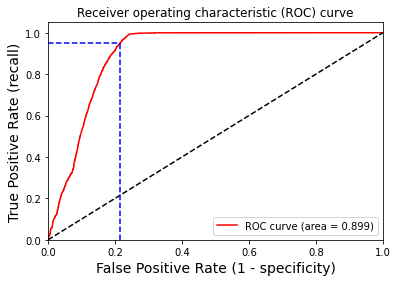

A threshold of 0.44 gives a sensitivity of 0.95 and a specificity of 0.78. The false positive rate is 0.22.


In [74]:
# Check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Results:')
print("Accuracy is: ", accuracy_score(y_test, y_pred))
print("Auc is:", auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensitivity > 0.95

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, fpr[idx]], [tpr[idx], tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx], fpr[idx]], [0, tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

thresh = round(thr[idx], 2)
sens = round(tpr[idx], 2)
spec = round((1-fpr[idx]), 2)
fprate = round(fpr[idx], 2)
print("A threshold of " + str(thresh) + " gives a sensitivity of "  + str(sens) +
      " and a specificity of " + str(spec) +". The false positive rate is " + str(fprate) + ".")

# Random Forest

In [75]:
#Random Forest Classifier score
rdmf = RandomForestClassifier(n_estimators=20, criterion='entropy')
rdmf.fit(X_train, y_train)

accuracies = []
rdmf_score = rdmf.score(X_test, y_test)
rdmf_score_tr = rdmf.score(X_train, y_train)
accuracies.append(rdmf_score)
print(rdmf_score)
print(rdmf_score_tr)

0.9789674431276393
0.9939244092986507


In [76]:
Y_prediction = rdmf.predict(X_test)
acc_random_forest = round(rdmf.score(X_train, y_train) * 100, 2)

In [77]:
#Ranking features based on order of importance [most impact to outcome]
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rdmf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(8)

,importance
feature,
MissedAppts,0.571
Age,0.112
DaysElapsed,0.102
DayOfTheWeek,0.042
SMS_received,0.014
Gender,0.013
Scholarship,0.006
Hypertension,0.006


## K-Nearest Neighbors

In [78]:
#K Nearest Neighbors classifier score

knn = KNeighborsClassifier(p=2, n_neighbors=10)
knn.fit(X_train, y_train)

knn_score = knn.score(X_test, y_test)
accuracies.append(knn_score)
print(knn_score)

0.870998501566544


## XGBoost

In [79]:
#XGBoost classifier score
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

/Users/ericjian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:24:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9116741588339463